# Ferma Challenge — Как начать 

Этот ноутбук поможет быстро стартовать с задачей по прогнозу годового удоя коровы. Здесь:

- краткое описание признаков;
- пример сохранения предсказаний для Kaggle (файл `ex.csv`)

## Описание данных

Каждая строка — отдельная корова.

| Column | Meaning |
| --- | --- |
| `cow_id` | Уникальный идентификатор коровы |
| `milk_yield_kg` | Годовой удой (кг) — целевой признак |
| `feed_energy_eke` | Энергетическая кормовая единица |
| `feed_crude_protein_g` | Содержание сырого протеина в корме (г) |
| `sugar_protein_ratio` | Сахаро-протеиновое соотношение |
| `breed` | Порода коровы |
| `pasture_type` | Тип пастбища |
| `sire_breed` | Порода отца |
| `milk_fat_pct` | Жирность молока (%) |
| `milk_protein_pct` | Белок в молоке (%) |
| `milk_taste_label` | Качественная оценка вкуса |
| `age_group` | Возрастная группа (`under_2_years`, `over_2_years`) |

Цель: построить модель, минимизирующую **MAE** при прогнозировании `milk_yield_kg`.

## МОЖНО НАЧИНАТЬ 

Импортируем всё чё надо :)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OneHotEncoder,
    PolynomialFeatures,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression  # простая модель

Прочитаем данные

In [ ]:

data_path = "../data/train.csv"
df = pd.read_csv(data_path, sep=',', decimal='.')

df.head()

In [ ]:
df.info()

In [ ]:
target_name = "milk_yield_kg"
X = df.drop(columns=[target_name])
y = df[target_name]


print("Доля пропусков:")
print(df.isna().mean().sort_values(ascending=False))
print()
print(f"Число наблюдений: {df.shape[0]}")
print(f"Число признаков (без таргета): {X.shape[1]}")
print()

print("Статистика:")
df.describe().T

Что здесь можно сказать: у нас нет пропусков, значит запонять ничего не будем. Видим лютый выброс у milk_yield_kg в виде 45616, при среднем 6197. Эту проблемку будем устранять, в остальных данных пока +- нормас всё.

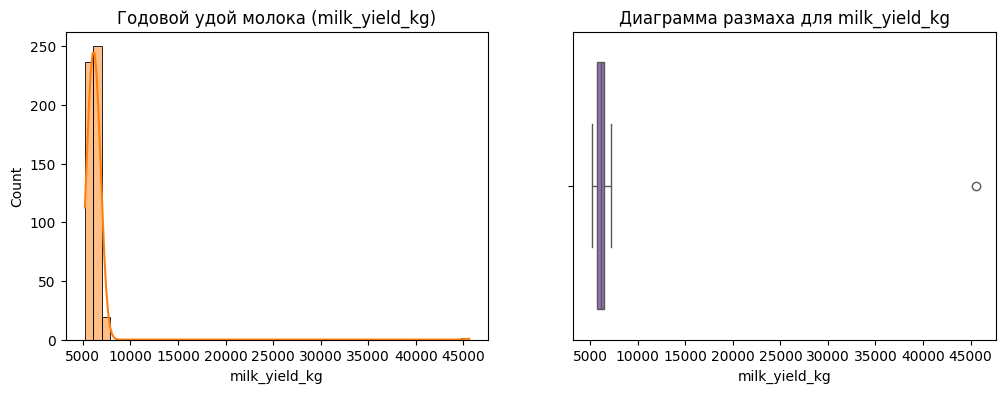

milk_yield_kg           20.339092
feed_crude_protein_g     0.534448
milk_protein_pct        -0.000412
cow_id                  -0.024645
feed_energy_eke         -0.295760
sugar_protein_ratio     -0.655786
milk_fat_pct            -1.710421
dtype: float64


In [129]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df[target_name], ax=axes[0], kde=True, color="tab:orange")
axes[0].set_title("Годовой удой молока (milk_yield_kg)")
axes[0].set_xlabel("milk_yield_kg")


sns.boxplot(x=df[target_name], ax=axes[1],color="tab:purple")
axes[1].set_title("Диаграмма размаха для milk_yield_kg")
axes[1].set_xlabel("milk_yield_kg")
plt.show()


skewness = df.select_dtypes(include=[np.number]).skew().sort_values(ascending=False)
print(skewness)


Действительно видим лютый хвост в milk_yield_kg. Используем IQR метод.

In [143]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df[target_name] >= lower_bound) & (df[target_name] <= upper_bound)]

In [137]:
X = df_clean.drop(['cow_id', target_name], axis=1)
y = df_clean[target_name]

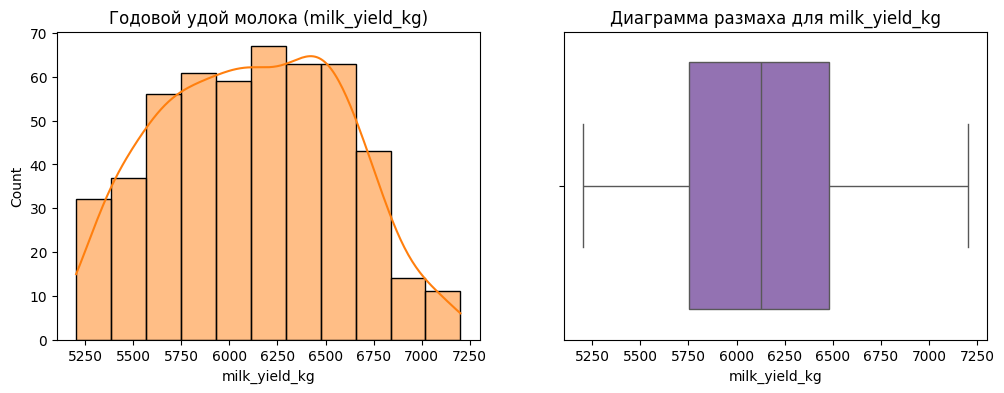

milk_yield_kg           20.339092
feed_crude_protein_g     0.534448
milk_protein_pct        -0.000412
cow_id                  -0.024645
feed_energy_eke         -0.295760
sugar_protein_ratio     -0.655786
milk_fat_pct            -1.710421
dtype: float64


In [197]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_clean[target_name], ax=axes[0], kde=True, color="tab:orange")
axes[0].set_title("Годовой удой молока (milk_yield_kg)")
axes[0].set_xlabel("milk_yield_kg")


sns.boxplot(x=df_clean[target_name], ax=axes[1],color="tab:purple")
axes[1].set_title("Диаграмма размаха для milk_yield_kg")
axes[1].set_xlabel("milk_yield_kg")
plt.show()


skewness = df.select_dtypes(include=[np.number]).skew().sort_values(ascending=False)
print(skewness)

Вот так сильно лучше. Зададим числовые и категориальные признаки, для прикола посмотрим что это.

In [199]:
print(f"Размер X (признаки): {X.shape}")
print(f"Размер y (цель): {y.shape}")
print()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

Размер X (признаки): (506, 10)
Размер y (цель): (506,)

Числовые признаки (5): ['feed_energy_eke', 'feed_crude_protein_g', 'sugar_protein_ratio', 'milk_fat_pct', 'milk_protein_pct']
Категориальные признаки (5): ['breed', 'pasture_type', 'sire_breed', 'milk_taste_label', 'age_group']


In [147]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]} строк")
print(f"Размер валидационной выборки: {X_test.shape[0]} строк")

Размер обучающей выборки: 404 строк
Размер валидационной выборки: 102 строк


признаки посмотрели, разбили выборку. Собираем пайплайн!

In [ ]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_features),
        ("cat", categorical_preprocess, categorical_features),
    ],
    remainder="drop",
)

preprocess_with_poly = Pipeline(steps=[
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
])

model = Pipeline(steps= [
    ("preprocess_with_poly", preprocess_with_poly),
    ("regressor", Lasso(alpha=1.12, max_iter=5000)),
])

model.fit(X_train, y_train)

,steps,"[('preprocess_with_poly', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('preprocess', ...), ('poly', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3


In [264]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 : {r2:.3f}")

MAE : 134.040
RMSE: 172.379
R^2 : 0.875


### Обязательные метрики
```
print(f"MAE : {mae}")
print(f"RMSE: {rmse}")
print(f"R^2 : {r2}")
```

## Подготовка файла для Kaggle
 Сохраняем файл  с колонками `cow_id` и `milk_yield_prediction`.

In [265]:
test_path = "../data/test.csv"
df_test = pd.read_csv(test_path, sep=',', decimal='.')
df_test.head()

test_cow_ids = df_test['cow_id'].copy()

X_test_kaggle = df_test.drop(['cow_id'], axis=1)


predictions = model.predict(X_test_kaggle)




submission = pd.DataFrame({
    "cow_id": test_cow_ids,
    "milk_yield_prediction": predictions,
})

submission.head()

,cow_id,milk_yield_prediction
0,397,6202.483769
1,249,6722.666791
2,216,5808.959002
3,354,6175.922253
4,549,6565.769629


In [266]:
submission_path = "ex.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved baseline submission to {submission_path}")

Saved baseline submission to ex.csv
